In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from RobotModel import RobotDynamicsModel, TransformerDecoderModel2D, TransformerDecoderModelWithLoRA

In [2]:
# Constants
h = 20  # history length
batch_size = 500 # Define batch size for DataLoader
train_val_split_ratio = 0.8  # 80% train, 20% validation
state_columns = ['x', 'y', 'yaw']
# Prepare the data
action_columns = ['accel', 'steer']

input_size = h * (len(state_columns) + len(action_columns))  # h * (|x| + |a|)

# Create sequences with history length h
num_of_augmentation = 1

In [3]:
finetuning_file_paths = ["../RC/Data/Mujoco.csv",
                        ]

finetuning_input_sequences = []
finetuning_output_sequences = []
finetuning_tot_duration = 0
finetuning_num_of_augmentation = num_of_augmentation



for file_path in finetuning_file_paths:
    path_data = pd.read_csv(file_path)

    # Display the first few rows
    path_data.head()
    times = np.array(path_data["timestamp"])
    dataset_duration = times[-1] - times[0]
    finetuning_tot_duration += dataset_duration
    print(f"{file_path} is {dataset_duration/60}m")
    states = path_data[state_columns].values
    actions = path_data[action_columns].values
    # plot_path(states)
    # cnt = 0
    for _ in range(finetuning_num_of_augmentation):
        # plot_path(augmented_states)
        for i in range(len(states) - h - 20 * 30):
            # Original sequence
            # plot_path(states[i:i + h + 1])
            if times[i+h] - times[i+h - 1] > 1/18:
                # cnt+=1
                continue

            # transformed_state = apply_relative_transformation(states[i:i + h + 1])
            transformed_state = states[i:i + h + 1]
            # plot_path(np.array(transformed_state))
            # break
            # plot_path(np.array(transformed_state))
            input_seq = np.concatenate((transformed_state[:h], actions[i:i + h]), axis=1).flatten()
            output_seq = transformed_state[h]
            finetuning_input_sequences.append(input_seq)
            finetuning_output_sequences.append(output_seq)
    # print(len(times) -  cnt)
print(f"Total duration is {finetuning_tot_duration/60}m")


# Convert to NumPy arrays and then to PyTorch tensors
finetuning_input_sequences = np.array(finetuning_input_sequences)
finetuning_output_sequences = np.array(finetuning_output_sequences)

# Convert to PyTorch tensors
finetuning_inputs = torch.tensor(finetuning_input_sequences, dtype=torch.float32)
finetuning_outputs = torch.tensor(finetuning_output_sequences, dtype=torch.float32)
# Check shapes
print(finetuning_inputs.shape, finetuning_outputs.shape)  # (samples, h * (|x| + |a|)), (samples, |x|)

# Dataset and DataLoader Setup
finetuning_dataset = TensorDataset(finetuning_inputs, finetuning_outputs)

# Split dataset into train, validation, and test sets (80-10-10 split)
finetuning_train_size = int(len(finetuning_dataset) * train_val_split_ratio)
finetuning_val_size = (len(finetuning_dataset) - finetuning_train_size) // 2
finetuning_test_size = len(finetuning_dataset) - finetuning_train_size - finetuning_val_size

finetuning_train_set, finetuning_val_set, finetuning_test_set = random_split(finetuning_dataset, [finetuning_train_size, finetuning_val_size, finetuning_test_size])

finetuning_train_loader = DataLoader(finetuning_train_set, batch_size=batch_size, shuffle=True)
finetuning_val_loader = DataLoader(finetuning_val_set, batch_size=batch_size, shuffle=False)
finetuning_test_loader = DataLoader(finetuning_test_set, batch_size=batch_size, shuffle=False)

../RC/Data/Mujoco.csv is 9.090855244795481m
Total duration is 9.090855244795481m
torch.Size([8124, 100]) torch.Size([8124, 3])


In [4]:
pretrained_model_path = 'Mujoco_model_v2.pth'
pretrained_state_dict = torch.load(pretrained_model_path)


finetuning_model = TransformerDecoderModelWithLoRA(input_size, len(state_columns), lora_r=4, lora_alpha=8)
finetuning_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
finetuning_model.to(device)

finetuning_model.load_state_dict(pretrained_state_dict, strict=False)

criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(finetuning_model.parameters(), lr=1e-4)

# LoRA 파라미터만 업데이트하도록 설정
lora_parameters = [p for n, p in finetuning_model.named_parameters() if 'lora' in n]
if len(lora_parameters) == 0:
    print("No LoRA parameters found!")
else:
    print(f"Number of LoRA parameters: {len(lora_parameters)}")

optimizer = torch.optim.Adam(lora_parameters, lr=1e-4)


def finetuning_evaluate(loader):
    finetuning_model.eval()  # Set model to evaluation mode
    total_loss, total_samples = 0, 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = finetuning_model(inputs)
            loss = criterion(predictions, targets)
            total_loss += loss.item() * len(targets)
            total_samples += len(targets)

    return total_loss / total_samples  # Return average loss

Number of LoRA parameters: 4


In [5]:
print(f"Training w {device}")
# Training loop with validation
finetuning_best_val_loss = float('inf')  # Initialize best validation loss to infinity
finetuning_train_losses, finetuning_val_losses = [], []
last_saved_epoch = - 10

cur_time = pd.Timestamp.now()
tag = f"{cur_time.year}_{cur_time.month}_{cur_time.day}_{cur_time.hour}_{cur_time.minute}"

num_epochs = 1000
for epoch in range(num_epochs):
    finetuning_model.train()
    
    finetuning_train_loss = 0
    for inputs, targets in finetuning_train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = finetuning_model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        finetuning_train_loss += loss.item() * len(targets)
    
    finetuning_train_loss /= len(finetuning_train_set)
    
    finetuning_val_loss = finetuning_evaluate(finetuning_val_loader)
    
    finetuning_train_losses.append(finetuning_train_loss)
    finetuning_val_losses.append(finetuning_val_loss)
    
    if finetuning_val_loss < finetuning_best_val_loss and epoch - last_saved_epoch > 10:
        last_saved_epoch = epoch
        finetuning_best_val_loss = finetuning_val_loss
        torch.save(finetuning_model.state_dict(), f'Mujoco_finetuned_model_{tag}_LoRA.pth')
        print(f"Saved Best Model at Epoch {epoch + 1} with Validation Loss: {finetuning_val_loss:.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

finetuning_test_loss = finetuning_evaluate(finetuning_test_loader)
print(f'Test Loss: {finetuning_test_loss:.4f}')

Training w cuda
Epoch [1/1000], Loss: 28.5462
Saved Best Model at Epoch 2 with Validation Loss: 26.1574
Epoch [2/1000], Loss: 29.2006
Epoch [3/1000], Loss: 26.2309
Epoch [4/1000], Loss: 28.5866
Epoch [5/1000], Loss: 28.4548
Epoch [6/1000], Loss: 24.8715
Epoch [7/1000], Loss: 25.2564
Epoch [8/1000], Loss: 28.4265
Epoch [9/1000], Loss: 19.7819
Epoch [10/1000], Loss: 25.8239
Epoch [11/1000], Loss: 23.7147
Epoch [12/1000], Loss: 23.5614
Saved Best Model at Epoch 13 with Validation Loss: 21.3214
Epoch [13/1000], Loss: 18.2896
Epoch [14/1000], Loss: 27.2031
Epoch [15/1000], Loss: 20.0655
Epoch [16/1000], Loss: 19.6405
Epoch [17/1000], Loss: 19.5194
Epoch [18/1000], Loss: 18.5065
Epoch [19/1000], Loss: 20.4270
Epoch [20/1000], Loss: 15.8477
Epoch [21/1000], Loss: 16.2431
Epoch [22/1000], Loss: 16.0218
Epoch [23/1000], Loss: 16.2304
Saved Best Model at Epoch 24 with Validation Loss: 13.8087
Epoch [24/1000], Loss: 13.6638
Epoch [25/1000], Loss: 14.8123
Epoch [26/1000], Loss: 11.7971
Epoch [27/1

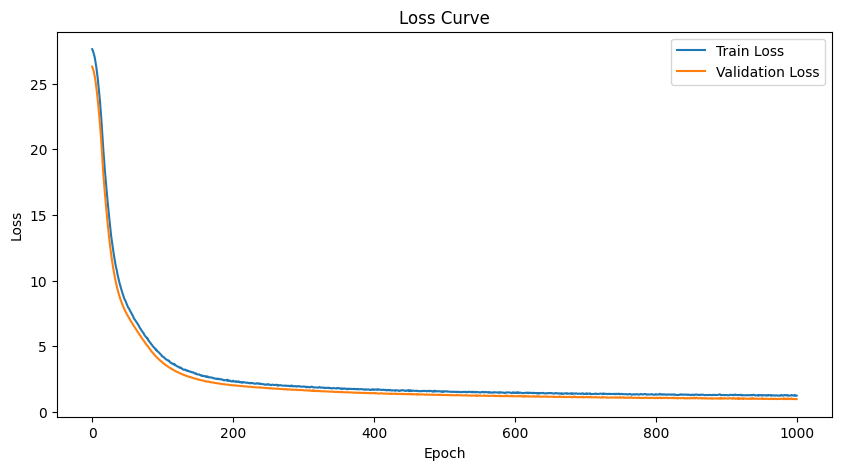

In [6]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(finetuning_train_losses, label='Train Loss')
plt.plot(finetuning_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()